In [ ]:
pip install pandas numpy matplotlib seaborn networkx 

In [ ]:
# Import necessary Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# Load the dataset from OECD STIP Survey with error handling
# url = "https://stip-pp.oecd.org/assets/downloads/STIP_Survey.csv"
url = "STIP_Survey.csv"
# Use low_memory=False to handle parsing issues and add error handling
try:
    stip_survey = pd.read_csv(url, sep="|", low_memory=False)
    print("Data loaded successfully!")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Trying alternative approach...")
    
    # Alternative approach with different parameters
    try:
        stip_survey = pd.read_csv(url, sep="|", low_memory=False, on_bad_lines='skip')
        print("Data loaded with error handling!")
    except Exception as e2:
        print(f"Alternative approach also failed: {e2}")
        raise

# Display basic information about the dataset
print("\nNumber of rows in the dataset:", len(stip_survey))
print("\nFirst 5 rows of the dataset:")
print(stip_survey.head())

In [ ]:
#To facilitate working with the dataset, we generate a separate 'Codebook' dataframe listing the column names and the detail given in the first row, for variables on themes and direct beneficiaries

# 1. Get column names (Code) and the first row (Meaning) from the DataFrame
columns = stip_survey.columns
meanings = stip_survey.iloc[0].values

# 2. Create a DataFrame pairing each column name with its description
codebook = pd.DataFrame({
    "Code": columns,
    "Meaning": meanings
})

# 3. Filter only columns whose names start with "TH" or "TG" (policy themes and direct beneficiaries)
codebook = codebook[codebook["Code"].str.match(r"^TH|^TG")].reset_index(drop=True)

# 4. Display the first 10 rows of the codebook
codebook.head(10)

In [ ]:
# Data preprocessing
# Remove the description row to keep only observational data
stip_survey = stip_survey.iloc[1:].reset_index(drop=True)

# Convert theme and target group columns to numeric format
th_tg_cols = [col for col in stip_survey.columns if col.startswith('TH') or col.startswith('TG')]
stip_survey[th_tg_cols] = stip_survey[th_tg_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Create a separate DataFrame with unique initiatives only
stip_survey_unique = stip_survey.drop_duplicates(subset=['InitiativeID']).copy()

print("Data loaded and prepared.")
print(f"Total policy instruments (rows): {len(stip_survey)}")
print(f"Total unique policy initiatives: {len(stip_survey_unique)}")
stip_survey_unique.head()

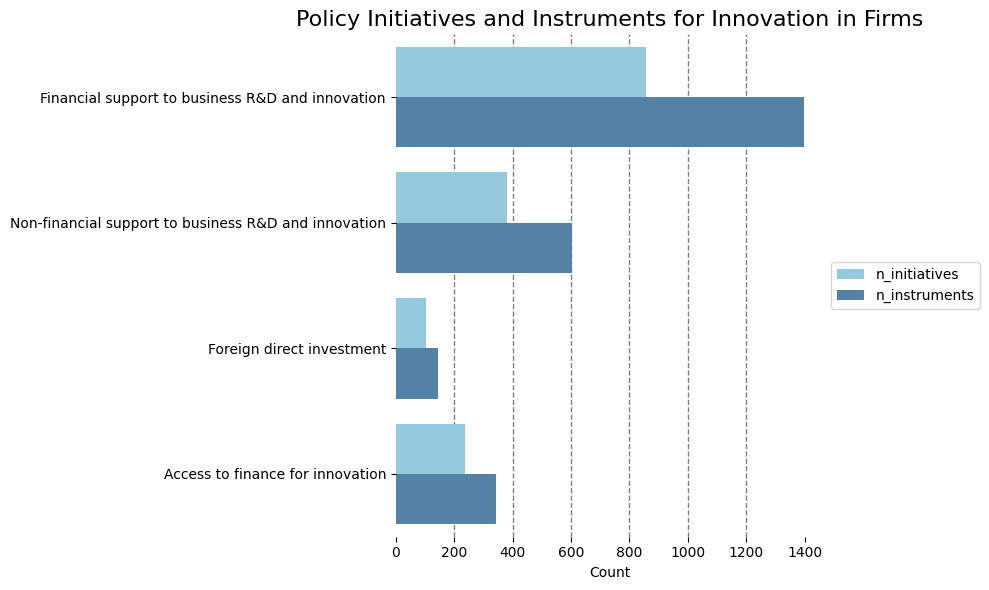

In [11]:

# --- 1. Remove columns that start with "F" (make a copy to avoid SettingWithCopyWarning) ---
financing_innovation = stip_survey.loc[:, ~stip_survey.columns.str.startswith('F')].copy()

# --- 2. Filter rows where at least one of the target themes is present ---
theme_cols = ['TH31', 'TH32', 'TH36', 'TH38']
# Ensure theme columns are numeric
financing_innovation[theme_cols] = financing_innovation[theme_cols].apply(pd.to_numeric, errors='coerce')
# Keep rows where the sum of these columns is greater than 0
financing_innovation = financing_innovation[financing_innovation[theme_cols].sum(axis=1) > 0]

# --- 3. Reshape to long format for the four themes ---
financing_long = financing_innovation.melt(
    id_vars=[col for col in financing_innovation.columns if col not in theme_cols],
    value_vars=theme_cols,
    var_name='Theme',
    value_name='value'
)
# Keep only rows where the theme is present (value == 1)
financing_long = financing_long[financing_long['value'] == 1]

# --- 4. Count the number of instruments per InitiativeID and Theme ---
grouped = financing_long.groupby(['InitiativeID', 'Theme']).size().reset_index(name='n_instruments')

# --- 5. For each Theme, keep only unique InitiativeID and summarize ---
unique_initiatives = grouped.drop_duplicates(subset=['Theme', 'InitiativeID'])
summary = unique_initiatives.groupby('Theme').agg(
    n_initiatives=('InitiativeID', 'nunique'),
    n_instruments=('n_instruments', 'sum')
).reset_index()
# --- 6. Map theme codes to descriptive labels for plotting ---
theme_labels = {
    'TH31': 'Financial support to business R&D and innovation',
    'TH32': 'Non-financial support to business R&D and innovation',
    'TH36': 'Foreign direct investment',
    'TH38': 'Access to finance for innovation'
}
summary['Theme_label'] = summary['Theme'].map(theme_labels)

# --- 7. Reshape summary for plotting (long format) ---
plot_df = pd.melt(
    summary,
    id_vars='Theme_label',
    value_vars=['n_initiatives', 'n_instruments'],
    var_name='Type',
    value_name='Count'
)

# --- 8. Plot grouped horizontal bar chart ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    y='Theme_label',
    x='Count',
    hue='Type',
    palette=['skyblue', 'steelblue']
)
for x in [200, 400, 600, 800, 1000,1200]:
    plt.axvline(x, color='gray', linestyle='--', lw=1, zorder=0)
sns.despine(left=True, bottom=True)

plt.title('Policy Initiatives and Instruments for Innovation in Firms', fontsize=16)
plt.xlabel('Count')
plt.ylabel('')
plt.legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

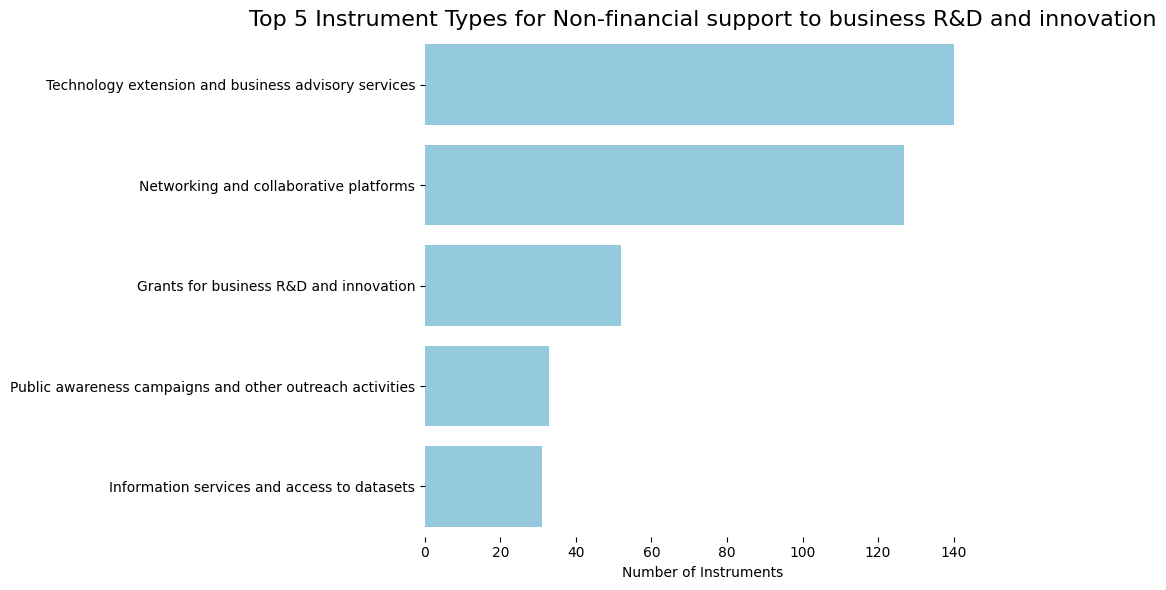

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Remove columns that start with "F"
th32_instruments = stip_survey.loc[:, ~stip_survey.columns.str.startswith('F')]

# 2. Filter rows where TH32 > 0 (ignore non-numeric rows)
th32_instruments = th32_instruments[
    pd.to_numeric(th32_instruments['TH32'], errors='coerce') > 0
]

# 3. Group by 'InstrumentTypeLabel' and count occurrences
th32_instruments = (
    th32_instruments
    .groupby('InstrumentTypeLabel')
    .size()
    .reset_index(name='n')
)

# 4. Get the top 5 by count, descending order
th32_instruments = th32_instruments.nlargest(5, 'n').sort_values('n', ascending=False)

# 5. Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=th32_instruments,
    y='InstrumentTypeLabel',
    x='n',
    color='skyblue'
)
sns.despine(left=True, bottom=True)
plt.title('Top 5 Instrument Types for Non-financial support to business R&D and innovation', fontsize=16)
plt.xlabel('Number of Instruments')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define the governance themes to analyze (use correct codes)
# New themes + related themes with high co-occurrence potential
governance_themes = [
    # New themes
    'TH111',  # Strategic autonomy and promotion of critical technologies
    'TH110',  # Dynamic skills and capabilities for policymaking
    'TH112',  # Net zero transitions in steel
    
    # Related themes with high co-occurrence potential
    'TH34',   # Dynamic and entrepreneurial capabilities and culture
    'TH13',   # STI plan or strategy
    'TH15',   # Evaluation and impact assessment
    'TH22',   # Structural change in the public research system
    
    # Additional themes that likely co-occur with new themes
    'TH31',   # Financial support to business R&D and innovation
    'TH32',   # Non-financial support to business R&D and innovation
    'TH82',   # Digital transformation of firms
    'TH91',   # Mission-oriented innovation policies
    'TH92',   # Net zero transitions in energy
    'TH103',  # Net zero transitions in transport and mobility
    'TH104',  # Net zero transitions in food and agriculture
    'TH89',   # Ethics and governance of emerging technologies
    'TH106',  # Digital transformation of research-performing organisations
    'TH109'   # Research security
]

# 2. English labels for the heatmap
label_mapping = {
    # New themes
    'TH111': 'Strategic Autonomy & Critical Technologies',
    'TH110': 'Dynamic Skills for Policymaking',
    'TH112': 'Net Zero Transitions in Steel',
    
    # Related themes
    'TH34': 'Dynamic & Entrepreneurial Capabilities',
    'TH13': 'STI Plan/Strategy',
    'TH15': 'Evaluation & Impact Assessment',
    'TH22': 'Structural Change in Public Research',
    
    # Additional related themes
    'TH31': 'Financial Support to Business R&D',
    'TH32': 'Non-financial Support to Business R&D',
    'TH82': 'Digital Transformation of Firms',
    'TH91': 'Mission-oriented Innovation Policies',
    'TH92': 'Net Zero Transitions in Energy',
    'TH103': 'Net Zero Transitions in Transport',
    'TH104': 'Net Zero Transitions in Food & Agriculture',
    'TH89': 'Ethics & Governance of Emerging Tech',
    'TH106': 'Digital Transformation of Research Org',
    'TH109': 'Research Security'
}

# 3. Check which themes are available in the dataset
available_themes = [theme for theme in governance_themes if theme in stip_survey_unique.columns]
print(f"Available themes in dataset: {len(available_themes)} out of {len(governance_themes)}")
print(f"Available themes: {available_themes}")

# 4. Create a DataFrame containing only available theme columns
governance_df = stip_survey_unique[available_themes].copy()
governance_df.columns = [label_mapping[col] for col in governance_df.columns]

# 5. Calculate the co-occurrence matrix
co_occurrence_matrix = governance_df.T.dot(governance_df)

# 6. Draw the heatmap with inverted color scheme
plt.figure(figsize=(16, 12))
sns.heatmap(co_occurrence_matrix, 
            annot=True, 
            fmt='d', 
            cmap='viridis_r',  # Blue color scheme inverted
            cbar_kws={'label': 'Number of Co-occurrences'})
plt.title('Co-occurrence Heatmap: New Themes and Related Policy Areas\n(Lighter colors = Lower relationship strength)', 
          fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
# 7. Print summary of co-occurrence patterns
print("\nCo-occurrence Analysis Summary:")
print("=" * 60)
print("New Themes (TH111, TH110, TH112) co-occurrence patterns:")

# Focus on new themes
new_themes = ['TH111', 'TH110', 'TH112']
for new_theme in new_themes:
    if new_theme in available_themes:
        theme_label = label_mapping[new_theme]
        print(f"\n{theme_label}:")
        
        # Get co-occurrence values for this theme
        theme_co_occurrences = co_occurrence_matrix.loc[label_mapping[new_theme]]
        
        # Sort by co-occurrence value (descending)
        sorted_co_occurrences = theme_co_occurrences.sort_values(ascending=False)
        
        # Show top 5 co-occurring themes
        print("Top 5 co-occurring themes:")
        # 修正: .items()を使用してキーと値のペアを取得
        for i, (theme, value) in enumerate(sorted_co_occurrences.head(6)[1:].items(), 1):
            print(f"  {i}. {theme}: {value} initiatives")

In [ ]:


import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Filter for instruments belonging to initiatives with the target theme.
dynamic_skills_instruments = stip_survey[stip_survey['TH34'] == 1]

# 2. Create a DataFrame of the relationships (edges) between countries and instruments.
#    We drop any rows with missing values in these key columns.
edges = dynamic_skills_instruments[['CountryLabel', 'InstrumentTypeLabel']].dropna().reset_index(drop=True)

# 3. Create a graph object from this list of edges using the networkx library.
G = nx.from_pandas_edgelist(edges, source='CountryLabel', target='InstrumentTypeLabel')

# 4. Prepare for plotting by defining node properties.
plt.figure(figsize=(16, 16)) # Use a large figure size for clarity
pos = nx.spring_layout(G, k=0.4, iterations=50) # Position nodes using a force-directed layout

# Differentiate nodes by type (country vs. instrument) for better visual interpretation.
node_colors = []
node_sizes = []
country_nodes = edges['CountryLabel'].unique()

for node in G.nodes():
    if node in country_nodes:
        node_colors.append('skyblue') # Color for countries
        node_sizes.append(2000)
    else:
        node_colors.append('lightgreen') # Color for instruments
        node_sizes.append(4000) # Larger nodes for instrument labels

# 5. Draw the network graph.
nx.draw(G, pos, 
        with_labels=True, 
        node_color=node_colors, 
        node_size=node_sizes,
        font_size=10, 
        font_weight='bold', 
        edge_color='gray',
        width=0.5)

plt.title('Network of Countries and Policy Instruments for "Dynamic Skills in Policymaking"', size=20)
plt.show()


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Configuration
categories = {
    'New': ['TH110', 'TH111', 'TH112'],
    'Governance': ['TH11', 'TH13', 'TH9', 'TH14', 'TH15', 'TH63', 'TH91', 'TH89', 'TH65'],
    'Research': ['TH16', 'TH18', 'TH19', 'TH20', 'TH27', 'TH22', 'TH106', 'TH107', 'TH108', 'TH24', 'TH25', 'TH26', 'TH23', 'TH21', 'TH109'],
    'Innovation': ['TH28', 'TH30', 'TH31', 'TH32', 'TH38', 'TH34', 'TH33', 'TH82', 'TH36', 'TH35'],
    'Knowledge': ['TH39', 'TH41', 'TH42', 'TH47', 'TH43', 'TH44', 'TH46'],
    'HR': ['TH48', 'TH50', 'TH51', 'TH52', 'TH53', 'TH55', 'TH54'],
    'Society': ['TH56', 'TH58', 'TH61', 'TH66'],
    'Net Zero': [ 'TH102', 'TH92', 'TH103', 'TH104']
}
colors = ['lightblue', 'red', 'green', 'blue', 'orange', 'purple', 'brown', 'darkgreen']

# Get available themes
themes = [t for cat in categories.values() for t in cat if t in stip_survey_unique.columns]
new_themes = ['TH110', 'TH111', 'TH112']

print(f"Available themes: {len(themes)}")
print(f"New themes: {[t for t in new_themes if t in themes]}")

# Create network relationships
relationships = []
for _, row in stip_survey_unique.iterrows():
    active = [t for t in themes if row[t] == 1]
    for i in range(len(active)):
        for j in range(i+1, len(active)):
            relationships.append((active[i], active[j]))

weights = Counter(relationships)

# Create graph
G = nx.Graph()
G.add_nodes_from(themes)
for (t1, t2), w in weights.items():
    if w >= 2:  # Only connections with 2+ co-occurrences
        G.add_edge(t1, t2, weight=w)

# Visualization setup
plt.figure(figsize=(20, 16))
pos = nx.spring_layout(G, k=2.0, seed=42)

# Node colors and labels
node_colors = []
node_labels = {}
for node in G.nodes():
    for i, (cat, cat_themes) in enumerate(categories.items()):
        if node in cat_themes:
            node_colors.append(colors[i])
            node_labels[node] = f"{node}\n({cat})" if cat != 'New' else f"{node}\n(NEW)"
            break

# Draw graph
edge_weights = [G[u][v]['weight'] for u, v in G.edges()] if G.edges() else []
max_w = max(edge_weights) if edge_weights else 1
edge_widths = [w/max_w * 5 for w in edge_weights]
node_sizes = [G.degree(n) * 200 for n in G.nodes()]

nx.draw(G, pos, with_labels=True, labels=node_labels, node_color=node_colors, 
        node_size=node_sizes, font_size=7, font_weight='bold', edge_color='gray',
        width=edge_widths, alpha=0.8)

# Legend
legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], 
                     markersize=15, label=cat) for i, cat in enumerate(categories.keys())]
plt.legend(handles=legend, loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.title('Policy Theme Network Analysis\n(TH110,111,112 in Light Blue)\nNode size = Connections, Edge thickness = Co-occurrence strength', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# Net Zero Transitions Comparison Analysis
# Create timeline comparison for TH102, TH92, TH103, TH104, and TH112

# Theme codes and labels based on the CSV reference
theme_codes = {
    'TH102': 'Government Capabilities for Net Zero Transitions',
    'TH92': 'Net Zero Transitions in Energy', 
    'TH103': 'Net Zero Transitions in Transport and Mobility',
    'TH104': 'Net Zero Transitions in Food and Agriculture',
    'TH112': 'Net Zero Transitions in Steel'
}

# Collect timeline data for each theme
timeline_dict = {}
available_themes = []

for code, label in theme_codes.items():
    if code in stip_survey_unique.columns:
        available_themes.append(code)
        # Filter initiatives for this theme
        initiatives = stip_survey_unique[stip_survey_unique[code] == 1].copy()
        
        if len(initiatives) > 0:
            # Convert StartDateYear to numeric
            initiatives['StartDateYear'] = pd.to_numeric(initiatives['StartDateYear'], errors='coerce')
            initiatives = initiatives.dropna(subset=['StartDateYear'])
            initiatives = initiatives[initiatives['StartDateYear'] > 2000]
            
            if len(initiatives) > 0:
                timeline = initiatives['StartDateYear'].value_counts().sort_index()
                timeline_dict[label] = timeline
                print(f"{code}: {len(initiatives)} initiatives found")
            else:
                print(f"{code}: No initiatives in specified time frame")
        else:
            print(f"{code}: No initiatives found")
    else:
        print(f"{code}: Theme not available in dataset")

# Create comparison plot
if len(timeline_dict) > 1:
    plt.figure(figsize=(14, 8))
    
    # Define colors for better visualization
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, (label, timeline) in enumerate(timeline_dict.items()):
        color = colors[i % len(colors)]
        plt.plot(timeline.index, timeline.values, marker='o', linestyle='-', 
                label=label, linewidth=2, markersize=6, color=color)
    
    plt.title('Comparison of Net Zero Transition Initiatives Timeline', fontsize=16, fontweight='bold')
    plt.xlabel('Year of Introduction', fontsize=12)
    plt.ylabel('Number of New Initiatives', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary of Net Zero Transition Initiatives:")
    print("=" * 50)
    for label, timeline in timeline_dict.items():
        total_initiatives = timeline.sum()
        years_active = len(timeline)
        peak_year = timeline.idxmax()
        peak_count = timeline.max()
        print(f"{label}:")
        print(f"  Total initiatives: {total_initiatives}")
        print(f"  Years active: {years_active}")
        print(f"  Peak year: {peak_year} ({peak_count} initiatives)")
        print()
        
else:
    print("Not enough themes available for comparison")

In [ ]:
 # Generate descriptive statistics for key year columns 
print(stip_survey[['SurveyYear', 'StartDateYear', 'EndDateYear']].describe())

 # Generate descriptive statistics for key year columns     
 # Count the number of unique policy initiatives per country 
# We use the 'stip_survey_unique' DataFrame to avoid overcounting 
top_countries = stip_survey_unique['CountryLabel'].value_counts() 
 
# Display the top 10 countries 
print(top_countries.head(10))